<a href="https://colab.research.google.com/github/jihun0423/Object-detection/blob/main/OpenCV_Yolo_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/DLCV-master

Mounted at /content/gdrive


image shape: (633, 806, 3)


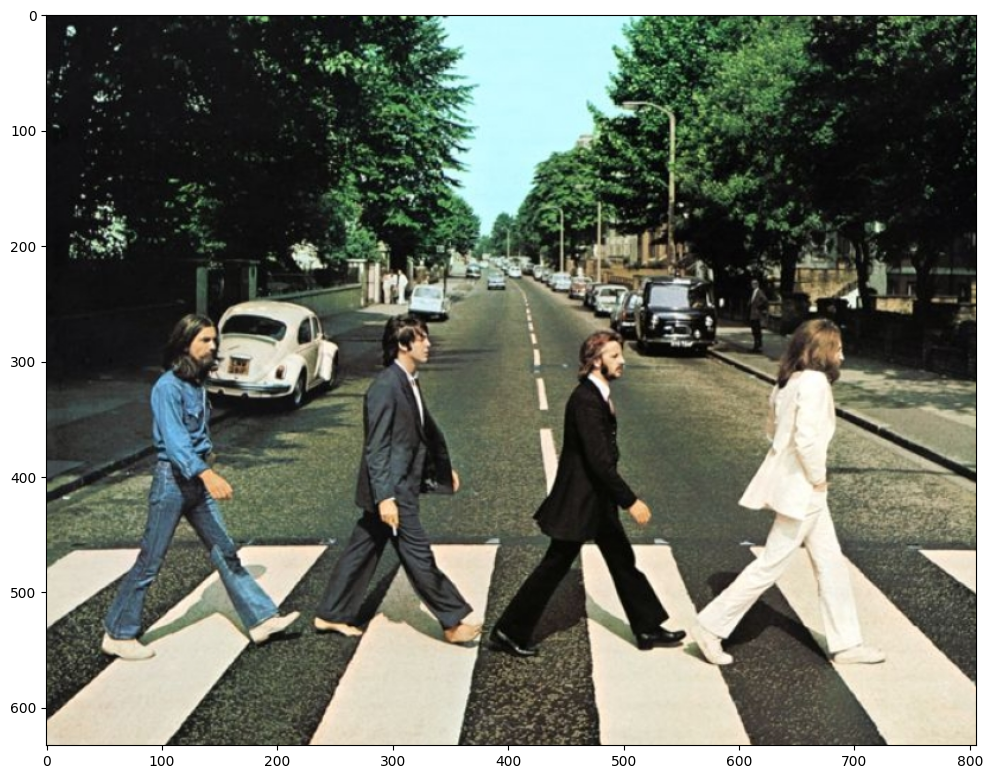

In [13]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('data/image/beatles01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### Darknet Yolo사이트에서 coco로 학습된 Inference모델와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성

* https://pjreddie.com/darknet/yolo/
* pretrained 모델은 wget https://pjreddie.com/media/files/yolov3.weights 에서 다운로드


#### readNetFromDarknet(config파일, weight파일)을 이용하여 yolo inference network 모델을 로딩

In [15]:
import os

CUR_DIR = 'Detection/yolo/'
weights_path = os.path.join(CUR_DIR, 'yolov3.weights')
config_path =  os.path.join(CUR_DIR, 'yolov3.cfg')
#config 파일 인자가 먼저 옴.
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

#### COCO class id와 class 명 매핑

In [16]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [17]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

#### 3개의 scale Output layer에서 결과 데이터 추출

In [19]:
layer_names = cv_net_yolo.getLayerNames()

In [21]:
cv_net_yolo.getUnconnectedOutLayers()

array([200, 227, 254], dtype=int32)

In [22]:
#전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
layer_names = cv_net_yolo.getLayerNames()
outlayer_names = [layer_names[i - 1] for i in cv_net_yolo.getUnconnectedOutLayers()]
print('output_layer name:', outlayer_names)

# 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
cv_net_yolo.setInput(cv2.dnn.blobFromImage(img, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cvOut으로 반환
cv_outs = cv_net_yolo.forward(outlayer_names)
# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)


output_layer name: ['yolo_82', 'yolo_94', 'yolo_106']


In [30]:
print(cv_outs[0].shape,cv_outs[1].shape,cv_outs[2].shape)

# (13x13x3, 4+1+80), (26x26x3, 4+1+80), (52x52x3, 4+1+80)

(507, 85) (2028, 85) (8112, 85)


#### 3개의 scale output layer에서 Object Detection 정보를 모두 수집.
* center와 width,height좌표는 모두 좌상단, 우하단 좌표로 변경.

In [23]:
import numpy as np

# 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함.
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]

conf_threshold = 0.5
nms_threshold = 0.4

class_ids = []
confidences = []
boxes = []

# 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화
for ix, output in enumerate(cv_outs):
    print('output shape:', output.shape)
    # Detected된 Object별 iteration
    for jx, detection in enumerate(output):
        # class score는 detetection배열에서 5번째 이후 위치에 있는 값.
        scores = detection[5:]
        # scores배열에서 가장 높은 값을 가지는 값이 class confidence, 그리고 그때의 위치 인덱스가 class id
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # confidence가 지정된 conf_threshold보다 작은 값은 제외
        if confidence > conf_threshold:
            print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
            # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
            # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
            center_x = int(detection[0] * cols)
            center_y = int(detection[1] * rows)
            width = int(detection[2] * cols)
            height = int(detection[3] * rows)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([left, top, width, height])

output shape: (507, 85)
ix: 0 jx: 316 class_id 0 confidence: 0.8499579
ix: 0 jx: 319 class_id 0 confidence: 0.9317014
ix: 0 jx: 325 class_id 0 confidence: 0.7301022
ix: 0 jx: 328 class_id 0 confidence: 0.96232516
ix: 0 jx: 334 class_id 0 confidence: 0.9984486
ix: 0 jx: 337 class_id 0 confidence: 0.98335254
ix: 0 jx: 343 class_id 0 confidence: 0.99784344
ix: 0 jx: 346 class_id 0 confidence: 0.6375212
output shape: (2028, 85)
ix: 1 jx: 831 class_id 2 confidence: 0.8169952
ix: 1 jx: 832 class_id 2 confidence: 0.71538025
ix: 1 jx: 877 class_id 2 confidence: 0.7854171
ix: 1 jx: 955 class_id 2 confidence: 0.8472685
ix: 1 jx: 1199 class_id 0 confidence: 0.7259739
ix: 1 jx: 1202 class_id 0 confidence: 0.9635835
ix: 1 jx: 1259 class_id 0 confidence: 0.9701872
ix: 1 jx: 1262 class_id 0 confidence: 0.9877816
ix: 1 jx: 1277 class_id 0 confidence: 0.992456
ix: 1 jx: 1280 class_id 0 confidence: 0.99840033
ix: 1 jx: 1295 class_id 0 confidence: 0.6916537
ix: 1 jx: 1313 class_id 0 confidence: 0.9205822

In [32]:
boxes

[[30, 249, 172, 315],
 [45, 250, 175, 314],
 [209, 245, 178, 307],
 [247, 243, 156, 307],
 [383, 266, 195, 292],
 [391, 268, 220, 292],
 [570, 259, 176, 302],
 [596, 255, 184, 314],
 [505, 228, 68, 66],
 [497, 228, 79, 66],
 [139, 242, 117, 95],
 [137, 247, 119, 93],
 [248, 248, 114, 276],
 [260, 243, 114, 286],
 [55, 267, 125, 278],
 [65, 271, 129, 268],
 [240, 255, 127, 286],
 [261, 253, 114, 290],
 [410, 281, 133, 254],
 [593, 269, 140, 280],
 [54, 274, 126, 284],
 [62, 274, 135, 284],
 [406, 286, 139, 262],
 [590, 282, 141, 269],
 [383, 219, 17, 17],
 [404, 216, 15, 11],
 [431, 222, 19, 16],
 [382, 225, 17, 13],
 [433, 223, 22, 18],
 [449, 226, 19, 18],
 [312, 235, 39, 32],
 [309, 235, 43, 32],
 [471, 233, 33, 29],
 [489, 238, 28, 42],
 [606, 229, 21, 63]]

#### NMS를 이용하여 각 Output layer에서 Detected된 Object의 겹치는 Bounding box를 제외.

In [33]:
conf_threshold = 0.5
nms_threshold = 0.4
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

print(idxs)

[ 4 17  6 15 30 28 24 32 11  8 34 33 25 29]


#### NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.

person: 0.9984
person: 0.9984
person: 0.9978
person: 0.9878
car: 0.9504
car: 0.9412
car: 0.9077
car: 0.9064
car: 0.8473
car: 0.8170
person: 0.7641
car: 0.6900
car: 0.6332
car: 0.6154


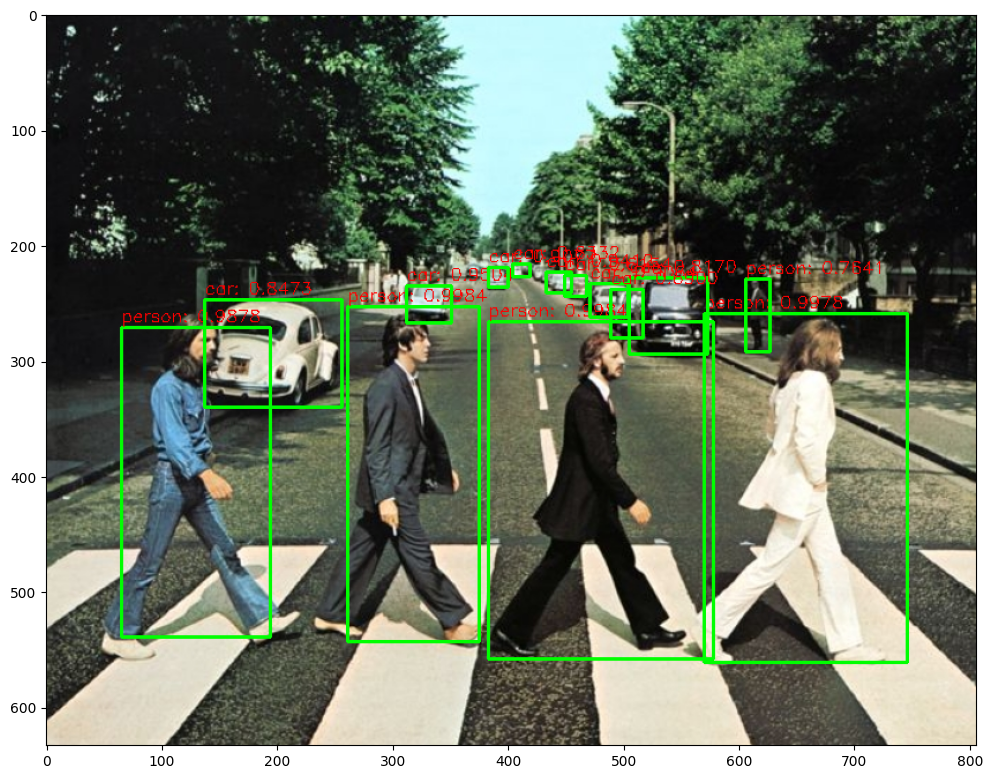

In [34]:
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)


#### 단일 이미지를 Yolo로 detect하는 get_detected_img() 함수 생성.

In [35]:
def get_detected_img(cv_net, img_array, conf_threshold, nms_threshold, use_copied_array=True, is_print=True):

    # 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함.
    # 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array

    #전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
    layer_names = cv_net.getLayerNames()
    outlayer_names = [layer_names[i - 1] for i in cv_net.getUnconnectedOutLayers()]

    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))
    start = time.time()
    # Object Detection 수행하여 결과를 cvOut으로 반환
    cv_outs = cv_net.forward(outlayer_names)
    layerOutputs = cv_net.forward(outlayer_names)
    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    class_ids = []
    confidences = []
    boxes = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외
            if confidence > conf_threshold:
                #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
                # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
                # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img

In [38]:
%cd /content/gdrive/MyDrive/DLCV-master

/content/gdrive/MyDrive/DLCV-master


Detection 수행시간: 3.99 초


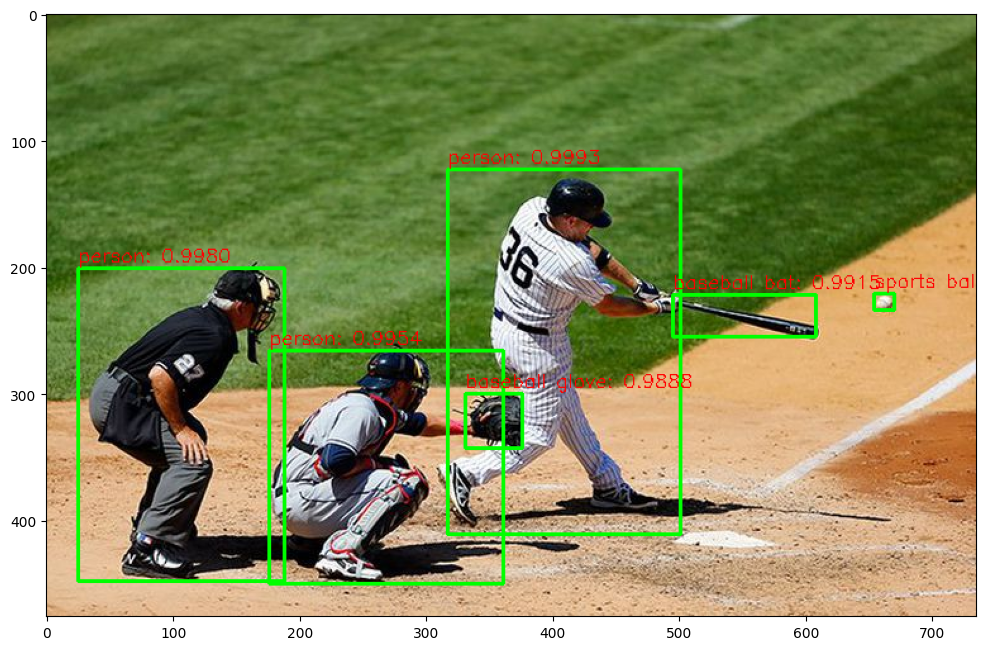

In [41]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time


# image 로드
img = cv2.imread('data/image/baseball01.jpg')

#coco dataset 클래스명 매핑

import os

CUR_DIR = 'Detection/yolo/'
weights_path = os.path.join(CUR_DIR, 'yolov3.weights')
config_path =  os.path.join(CUR_DIR, 'yolov3.cfg')
#config 파일 인자가 먼저 옴.
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

conf_threshold = 0.5
nms_threshold = 0.4
# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### 영상 Object Detection

In [42]:
def do_detected_video(cv_net, input_path, output_path,conf_threshold,nms_threshold, is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    #green_color=(0, 255, 0)
    #red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        returned_frame = get_detected_img(cv_net, img_frame, conf_threshold=conf_threshold, nms_threshold=nms_threshold, \
                                          use_copied_array=False, is_print=is_print)
        vid_writer.write(returned_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [43]:
do_detected_video(cv_net_yolo, 'bryant.mp4', 'bryant_yoloV3.avi', conf_threshold,
                  nms_threshold, True)

총 Frame 갯수: 95
Detection 수행시간: 2.14 초
Detection 수행시간: 3.28 초
Detection 수행시간: 3.65 초
Detection 수행시간: 3.33 초
Detection 수행시간: 2.32 초
Detection 수행시간: 2.09 초
Detection 수행시간: 2.08 초
Detection 수행시간: 2.49 초
Detection 수행시간: 3.14 초
Detection 수행시간: 2.2 초
Detection 수행시간: 2.02 초
Detection 수행시간: 2.34 초
Detection 수행시간: 3.18 초
Detection 수행시간: 3.21 초
Detection 수행시간: 2.93 초
Detection 수행시간: 2.07 초
Detection 수행시간: 2.06 초
Detection 수행시간: 2.07 초
Detection 수행시간: 2.06 초
Detection 수행시간: 2.46 초
Detection 수행시간: 3.19 초
Detection 수행시간: 2.2 초
Detection 수행시간: 2.05 초
Detection 수행시간: 2.1 초
Detection 수행시간: 2.05 초
Detection 수행시간: 2.16 초
Detection 수행시간: 3.15 초
Detection 수행시간: 2.54 초
Detection 수행시간: 2.07 초
Detection 수행시간: 2.05 초
Detection 수행시간: 2.08 초
Detection 수행시간: 2.09 초
Detection 수행시간: 2.94 초
Detection 수행시간: 2.87 초
Detection 수행시간: 2.11 초
Detection 수행시간: 2.11 초
Detection 수행시간: 2.11 초
Detection 수행시간: 2.06 초
Detection 수행시간: 2.7 초
Detection 수행시간: 3.15 초
Detection 수행시간: 2.09 초
Detection 수행시간: 2.05 초
Detection 수행시간: 2.05 초


### tiny Yolo로 Object Detection 수행하기.
* tiny yolo의 pretrained된 weight파일은 wget https://pjreddie.com/media/files/yolov3-tiny.weights 에서 download 가능.
* config 파일은 wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg 로 다운로드

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

# image 로드
img = cv2.imread('../../data/image/beatles01.jpg')

#coco dataset 클래스명 매핑

import os
#가급적 절대 경로 사용.
CUR_DIR = os.path.abspath('.')
weights_path = os.path.join(CUR_DIR, './pretrained/yolov3-tiny.weights')
config_path =  os.path.join(CUR_DIR, './pretrained/yolov3-tiny.cfg')

# tensorflow inference 모델 로딩
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

#tiny yolo의 경우 confidence가 일반적으로 낮음.
conf_threshold = 0.3
nms_threshold = 0.4
# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net_yolo, img, conf_threshold=conf_threshold, nms_threshold=nms_threshold, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### tiny yolo로 영상 Detection

In [ ]:
do_detected_video(cv_net_yolo, '../../data/video/John_Wick_small.mp4', '../../data/output/John_Wick_small_tiny_yolo01.avi', conf_threshold,
                  nms_threshold, True)

In [ ]:
!gsutil cp ../../data/output/John_Wick_small_tiny_yolo01.avi gs://my_bucket_dlcv/data/output/John_Wick_small_tiny_yolo01.avi